<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import patsy

from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_rand
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets, linear_model, preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from itertools import combinations
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
# Load the data
house = pd.read_csv('./housing.csv')

In [4]:
house.shape

(1460, 81)

In [5]:
house.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,"2,003.00",RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,"1,976.00",RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.00,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,"2,001.00",RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.00,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.00,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,"1,998.00",Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.00,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,"2,000.00",RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.00,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.00,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,"1,993.00",Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.00,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.00,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,"2,004.00",RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,nan,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.00,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,"1,973.00",RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.00,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.00,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,"1,931.00",Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.00,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,No

In [6]:
house.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,"1,460.00","1,460.00","1,201.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,452.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,379.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00"
mean,730.50,56.90,70.05,"10,516.83",6.10,5.58,"1,971.27","1,984.87",103.69,443.64,46.55,567.24,"1,057.43","1,162.63",346.99,5.84,"1,515.46",0.43,0.06,1.57,0.38,2.87,1.05,6.52,0.61,"1,978.51",1.77,472.98,94.24,46.66,21.95,3.41,15.06,2.76,43.49,6.32,"2,007.82","180,921.20"
std,421.61,42.30,24.28,"9,981.26",1.38,1.11,30.20,20.65,181.07,456.10,161.32,441.87,438.71,386.59,436.53,48.62,525.48,0.52,0.24,0.55,0.50,0.82,0.22,1.63,0.64,24.69,0.75,213.80,125.34,66.26,61.12,29.32,55.76,40.18,496.12,2.70,1.33,"79,442.50"
min,1.00,20.00,21.00,"1,300.00",1.00,1.00,"1,872.00","1,950.00",0.00,0.00,0.00,0.00,0.00,334.00,0.00,0.00,334.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,"1,900.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,"2,006.00","34,900.00"
25%,365.75,20.00,59.00,"7,553.50",5.00,5.00,"1,954.00","1,967.00",0.00,0.00,0.00,223.00,795.75,882.00,0.00,0.00,"1,129.50",0.00,0.00,1.00,0.00,2.00,1.00,5.00,0.00,"1,961.00",1.00,334.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,"2,007.00","129,975.00"
50%,730.50,50.00,69.00,"9,478.50",6.00,5.00,"1,973.00","1,994.00",0.00,383.50,0.00,477.50,991.50,"1,087.00",0.00,0.00,"1,464.00",0.00,0.00,2.00,0.00,3.00,1.00,6.00,1.00,"1,980.00",2.00,480.00,0.00,25.00,0.00,0.00,0.00,0.00,0.00,6.00,"2,008.00","163,000.00"
75%,"1,095.25",70.00,80.00,"11,601.50",7.00,6.00,"2,000.00","2,004.00",166.00,712.25,0.00,808.00,"1,298.25","1,391.25",728.00,0.00,"1,776.75",1.00,0.00,2.00,1.00,3.00,1.00,7.00,1.00,"2,002.00",2.00,576.00,168.00,68.00,0.00,0.00,0.00,0.00,0.00,8.00,"2,009.00","214,000.00"
max,"1,460.00",190.00,313.00,"215,245.00",10.00,9.00,"2,010.00","2,010.00","1,600.00","5,644.00","1,474.00","2,336.00","6,110.00","4,692.00","2,065.00",572.00,"5,642.00",3.00,2.00,3.00,2.00,8.00,3.00,14.00,3.00,"2,010.00",4.00,"1,418.00",857.00,547.00,552.00,508.00,480.00,738.00,"15,500.00",12.00,"2,010.00","755,000.00"


In [7]:
house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [8]:
house.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

In [9]:
house.drop(columns='Id',inplace=True, axis=1)
house.drop(index=house.loc[house.MSZoning == 'C (all)'].index,inplace=True)
house.drop(index=1379,inplace=True) #Drop electrical with null value
house.drop(index=house.loc[house.MasVnrType.isnull() == True].index,inplace=True)

In [10]:
house_orig = house.copy()

In [11]:
house['Alley'] = house.Alley.fillna(value='NA')
house['PoolQC'] = house.PoolQC.fillna(value='NA')
house['Fence'] = house.Fence.fillna(value='NA')
house['GarageType'] = house.GarageType.fillna(value='NA')
house['MiscFeature'] = house.MiscFeature.fillna(value='NA')
house['FireplaceQu'] = house.FireplaceQu.fillna(value='NA')
house['BsmtQual'] = house.BsmtQual.fillna(value='NA')
house['BsmtCond'] = house.BsmtCond.fillna(value='NA')
house['BsmtExposure'] = house.BsmtExposure.fillna(value='NA')
house['BsmtFinType1'] = house.BsmtFinType1.fillna(value='NA')
house['BsmtFinType2'] = house.BsmtFinType2.fillna(value='NA')
house['GarageFinish'] = house.GarageFinish.fillna(value='NA')
house['GarageQual'] = house.GarageQual.fillna(value='NA')
house['GarageCond'] = house.GarageCond.fillna(value='NA')

house['LotFrontage'] = house.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
house['GarageYrBlt'].fillna(value=house['GarageYrBlt'].mean(),inplace=True)
house['MasVnrArea'].fillna(value=house['MasVnrArea'].mean(),inplace=True)

house['Neighborhood'] = LabelEncoder().fit_transform(house['Neighborhood'])
house['LotShape'] = LabelEncoder().fit_transform(house['LotShape'])
house['HouseStyle'] = LabelEncoder().fit_transform(house['HouseStyle'])
house['GarageType'] = LabelEncoder().fit_transform(house['GarageType'])
house['BsmtQual'] = LabelEncoder().fit_transform(house['BsmtQual'])
house['BsmtCond'] = LabelEncoder().fit_transform(house['BsmtCond'])
house['BsmtExposure'] = LabelEncoder().fit_transform(house['BsmtExposure'])
house['BsmtFinType1'] = LabelEncoder().fit_transform(house['BsmtFinType1'])
house['BsmtFinType2'] = LabelEncoder().fit_transform(house['BsmtFinType2'])
house['GarageFinish'] = LabelEncoder().fit_transform(house['GarageFinish'])
house['GarageQual'] = LabelEncoder().fit_transform(house['GarageQual'])
house['GarageCond'] = LabelEncoder().fit_transform(house['GarageCond'])

house['RoofStyle'] = LabelEncoder().fit_transform(house['RoofStyle'])
house['RoofMatl'] = LabelEncoder().fit_transform(house['RoofMatl'])
house['Exterior1st'] = LabelEncoder().fit_transform(house['Exterior1st'])
house['Exterior2nd'] = LabelEncoder().fit_transform(house['Exterior2nd'])
house['MasVnrType'] = LabelEncoder().fit_transform(house['MasVnrType'])
house['Foundation'] = LabelEncoder().fit_transform(house['Foundation'])
house['Heating'] = LabelEncoder().fit_transform(house['Heating'])
house['CentralAir'] = LabelEncoder().fit_transform(house['CentralAir'])
house['Electrical'] = LabelEncoder().fit_transform(house['Electrical'])
house['Fence'] = LabelEncoder().fit_transform(house['Fence'])
house['MiscFeature'] = LabelEncoder().fit_transform(house['MiscFeature'])

house['ExterQual'] = LabelEncoder().fit_transform(house['ExterQual'])
house['ExterCond'] = LabelEncoder().fit_transform(house['ExterCond'])
house['BsmtQual'] = LabelEncoder().fit_transform(house['BsmtQual'])
house['BsmtCond'] = LabelEncoder().fit_transform(house['BsmtCond'])
house['BsmtExposure'] = LabelEncoder().fit_transform(house['BsmtExposure'])
house['HeatingQC'] = LabelEncoder().fit_transform(house['HeatingQC'])
house['KitchenQual'] = LabelEncoder().fit_transform(house['KitchenQual'])
house['FireplaceQu'] = LabelEncoder().fit_transform(house['FireplaceQu'])
house['GarageFinish'] = LabelEncoder().fit_transform(house['GarageFinish'])
house['GarageQual'] = LabelEncoder().fit_transform(house['GarageQual'])
house['GarageCond'] = LabelEncoder().fit_transform(house['GarageCond'])
house['PoolQC'] = LabelEncoder().fit_transform(house['PoolQC'])

house['MSZoning'] = LabelEncoder().fit_transform(house['MSZoning'])
house['Street'] = LabelEncoder().fit_transform(house['Street'])
house['Alley'] = LabelEncoder().fit_transform(house['Alley'])
house['LandContour'] = LabelEncoder().fit_transform(house['LandContour'])
house['Utilities'] = LabelEncoder().fit_transform(house['Utilities'])
house['LotConfig'] = LabelEncoder().fit_transform(house['LotConfig'])
house['LandSlope'] = LabelEncoder().fit_transform(house['LandSlope'])
house['Condition1'] = LabelEncoder().fit_transform(house['Condition1'])
house['Condition2'] = LabelEncoder().fit_transform(house['Condition2'])
house['BldgType'] = LabelEncoder().fit_transform(house['BldgType'])
house['Functional'] = LabelEncoder().fit_transform(house['Functional'])
house['PavedDrive'] = LabelEncoder().fit_transform(house['PavedDrive'])
house['SaleType'] = LabelEncoder().fit_transform(house['SaleType'])
house['SaleCondition'] = LabelEncoder().fit_transform(house['SaleCondition'])

In [12]:
house_fixed = house[['MSSubClass', 'LotArea', 'LotFrontage', 'LotShape', 'Neighborhood', '1stFlrSF', 
                     '2ndFlrSF', 'HouseStyle', 'GarageCars', 'GarageArea', 'TotalBsmtSF','BedroomAbvGr',
                     'BsmtFullBath', 'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'GarageType', 'MSZoning', 
                     'Street', 'Alley', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1',
                     'Condition2', 'BldgType', 'MasVnrArea', 'BsmtFinSF1', 'YrSold',
                     'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'Functional',
                     'GarageYrBlt', 'GarageCars', 'GarageArea', 'PavedDrive', 'MiscVal'
                    ]]

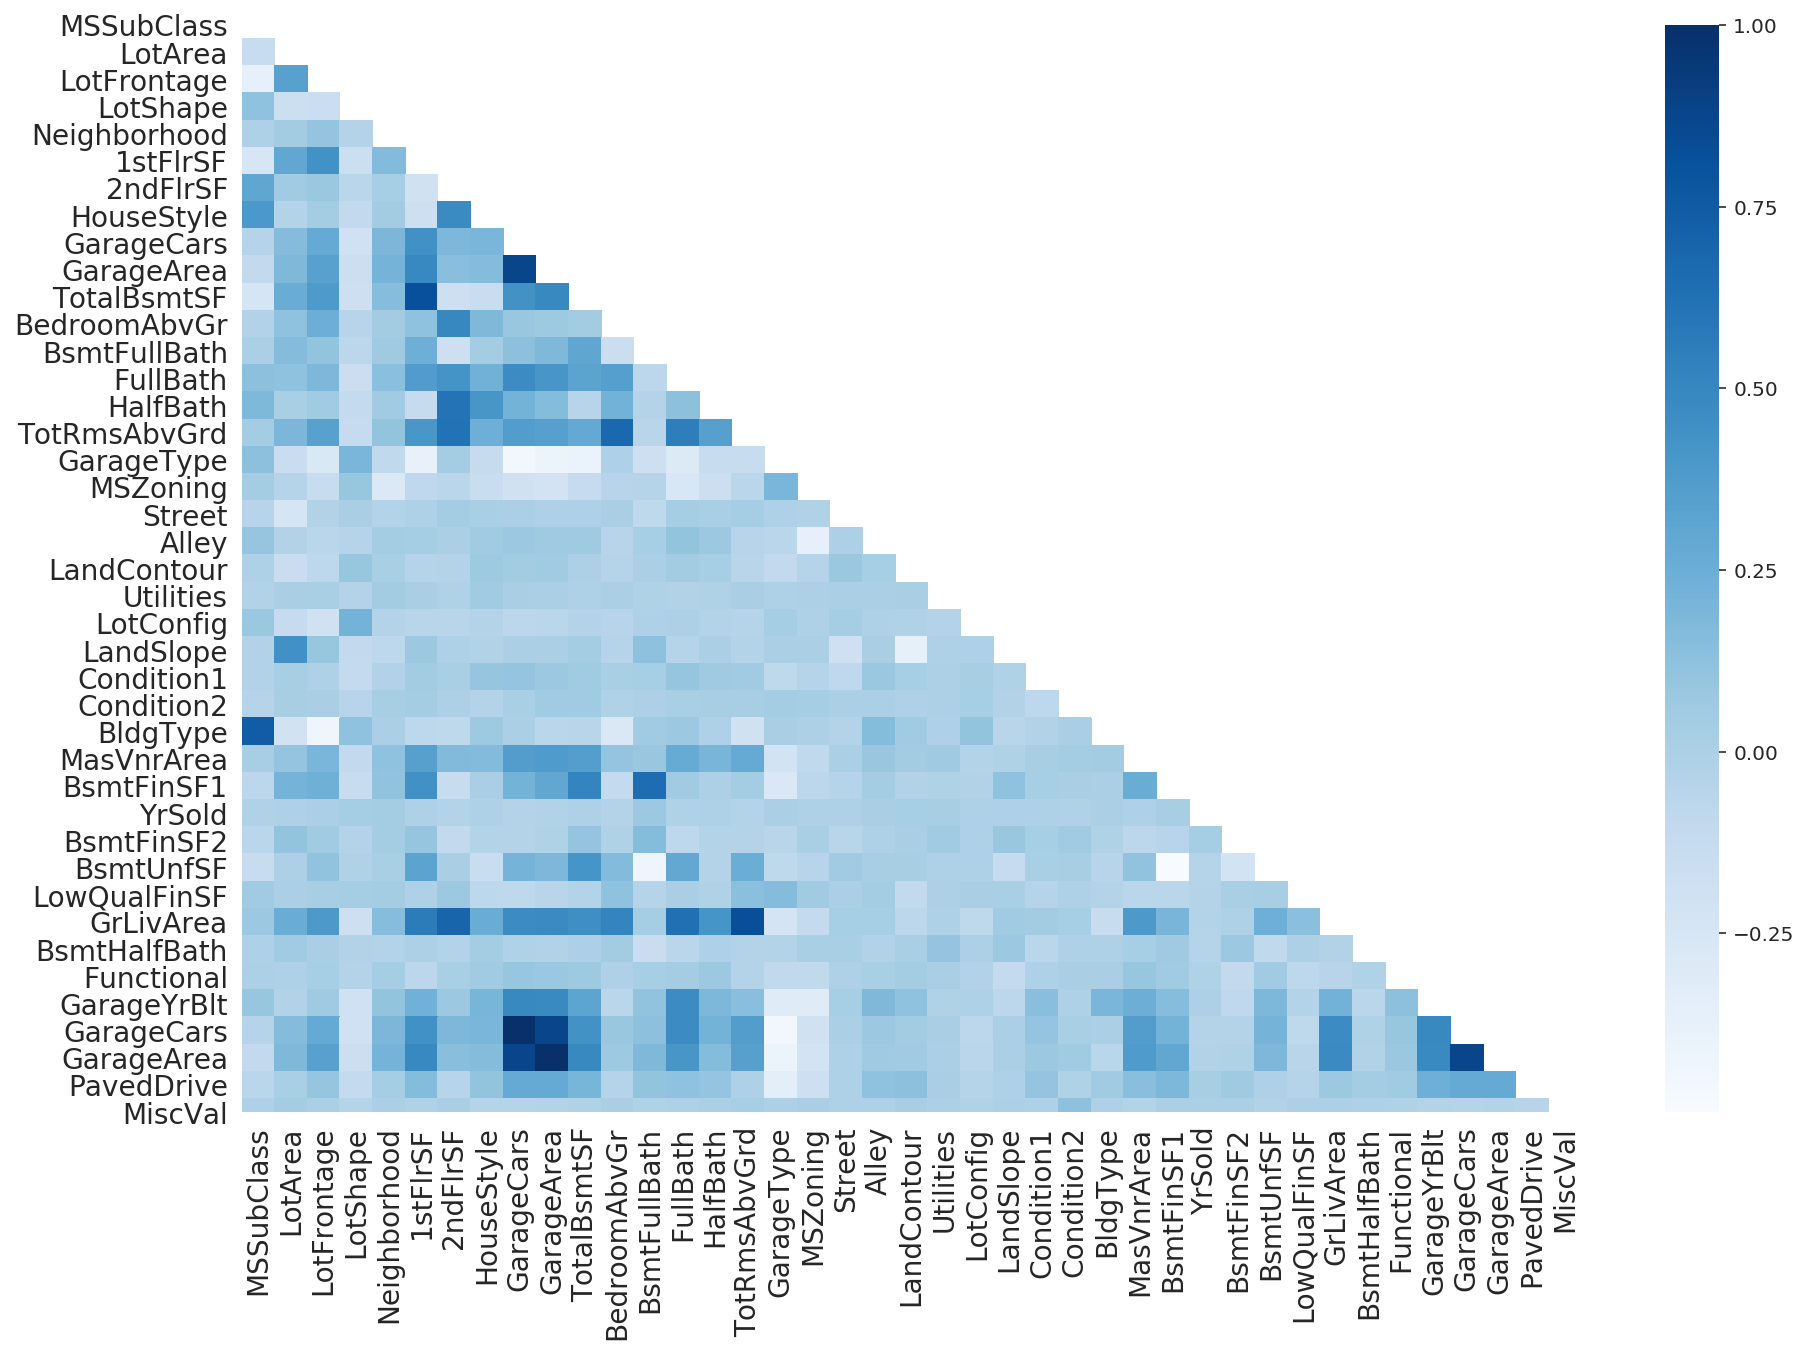

In [13]:
# plot heatmap to check correlation

data_corr = house_fixed.corr()
# Set the default matplotlib figure size:
fig, ax = plt.subplots(figsize=(15, 10))
# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(data_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(data_corr, mask=mask, ax=ax, cmap='Blues')
# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)
plt.show()

The neighborhood
Square feet - 'LotArea'
Bedrooms - Bedroom, bathrooms - FullBath
Basement and garage space

In [14]:
X = house_fixed.values
y = house.SalePrice

In [15]:
X_train = house_fixed.loc[house_fixed.YrSold < 2010].values
y_train = house.SalePrice.loc[house.loc[house.YrSold < 2010].index]

In [16]:
X_test = house_fixed.loc[house_fixed.YrSold >= 2010].values
y_test = house.SalePrice.loc[house.loc[house.YrSold >= 2010].index]

# Training

In [17]:
lr_pipe = make_pipeline(MinMaxScaler(), LinearRegression())

In [18]:
#Linear Regression

lr_pipe.fit(X_train, y_train)
lr_score = lr_pipe.score(X_test,y_test)

print(lr_score)

0.8101461266147123


In [19]:
kn_pipe = make_pipeline(MinMaxScaler(), KNeighborsClassifier(n_neighbors=10,weights='distance'))

In [20]:
#K nearest neighbors

kn_pipe.fit(X_train,y_train)
kn_score = kn_pipe.score(X_test,y_test)

print(kn_score)

0.005847953216374269


In [21]:
# prepare a range of alpha values to test
alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
# create and fit a ridge regression model, testing each alpha
model = Ridge()
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))
grid.fit(X_train,y_train)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)

GridSearchCV(cv=None, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 0.e+00])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)
0.7050396849665881
1.0


In [22]:
# prepare a uniform distribution to sample for the alpha parameter
param_grid = {'alpha': sp_rand()}
# create and fit a ridge regression model, testing random alpha values
model = Ridge()
rsearch = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=100)
rsearch.fit(X_train,y_train)
print(rsearch)
# summarize the results of the random parameter search
print(rsearch.best_score_)
print(rsearch.best_estimator_.alpha)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                                   max_iter=None, normalize=False,
                                   random_state=None, solver='auto',
                                   tol=0.001),
                   iid='deprecated', n_iter=100, n_jobs=None,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa8a5211650>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)
0.70503781598512
0.9924823062213587


In [23]:
ridge_alphas = [1e-3, 1e-2, 1e-1, 1]
ridge_CV = RidgeCV(alphas=ridge_alphas, cv=10, normalize=True)

In [24]:
ridge_CV.fit(X_train, y_train)
ridge_score = ridge_CV.score(X_test,y_test)
print(ridge_score)

0.8066253871564788


In [25]:
# lasso_pipe = make_pipeline(MinMaxScaler(), LassoCV(n_alphas=500, cv=10, verbose=0))
lasso_alphas = [1e-3, 1e-2, 1e-1, 1]
lasso_CV = LassoCV(alphas=lasso_alphas, cv=StratifiedKFold(shuffle=True,random_state=5), 
                     normalize=True,max_iter=10000,tol=0.01)

In [26]:
lasso_CV.fit(X_train,y_train)
lasso_score = lasso_CV.score(X_test,y_test)
print(lasso_score)

0.8104559649366578


/home/glitch/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [27]:
lasso_coefs = pd.DataFrame({'variable':house_fixed.columns,
                            'coef':lasso_CV.coef_,
                            'abs_coef':np.abs(lasso_CV.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head()

,variable,coef,abs_coef
21,Utilities,"-51,106.82","51,106.82"
8,GarageCars,"21,688.53","21,688.53"
11,BedroomAbvGr,"-16,533.54","16,533.54"
18,Street,"13,803.65","13,803.65"
12,BsmtFullBath,"13,510.59","13,510.59"


# Model

In [28]:
ridge_CV.fit(X, y)
lasso_CV.fit(X, y)

/home/glitch/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


LassoCV(alphas=[0.001, 0.01, 0.1, 1], copy_X=True,
        cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True), eps=0.001,
        fit_intercept=True, max_iter=10000, n_alphas=100, n_jobs=None,
        normalize=True, positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.01, verbose=False)

In [29]:
lasso_score_final = lasso_CV.score(X,y)
ridge_score_final = ridge_CV.score(X,y)
print(lasso_score_final)
print(ridge_score_final)

0.7628315541739084
0.7598273870741459


In [30]:
lasso_predict = lasso_CV.predict(X)
ridge_predict = ridge_CV.predict(X)

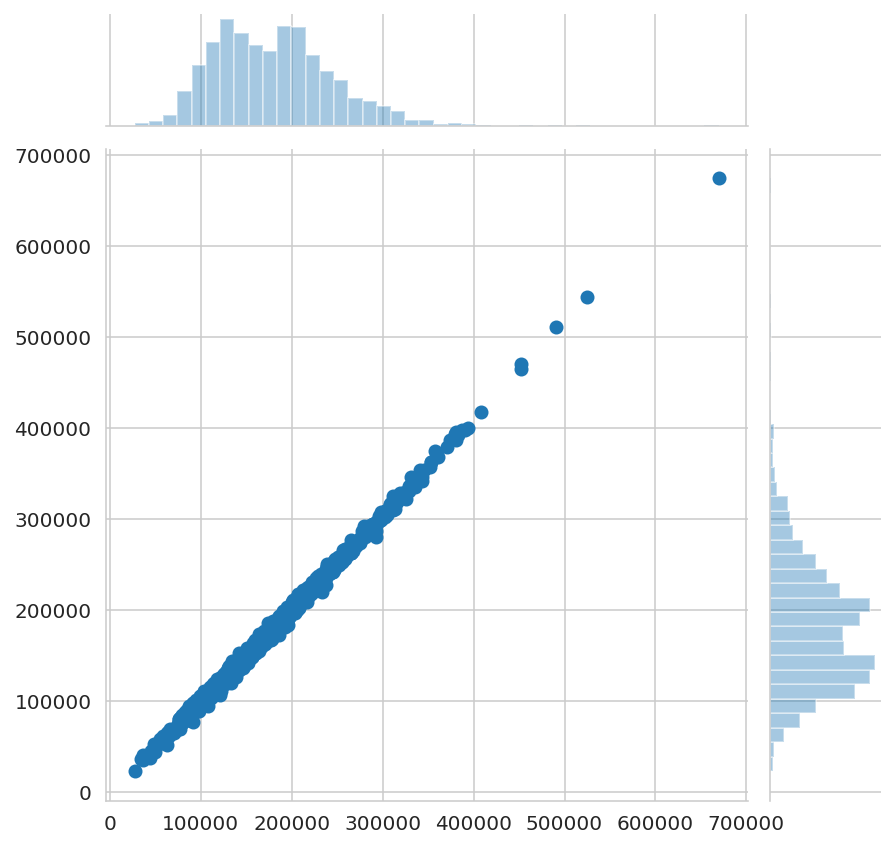

In [31]:
sns.jointplot(ridge_predict, lasso_predict)

In [32]:
Predicted_SalePrice_Fix = pd.DataFrame(lasso_predict,columns=['Predicted SalePrice_Fix'])

## Residuals

In [33]:
ridge_resid = y - ridge_CV.predict(X)
lasso_resid = y - lasso_CV.predict(X)

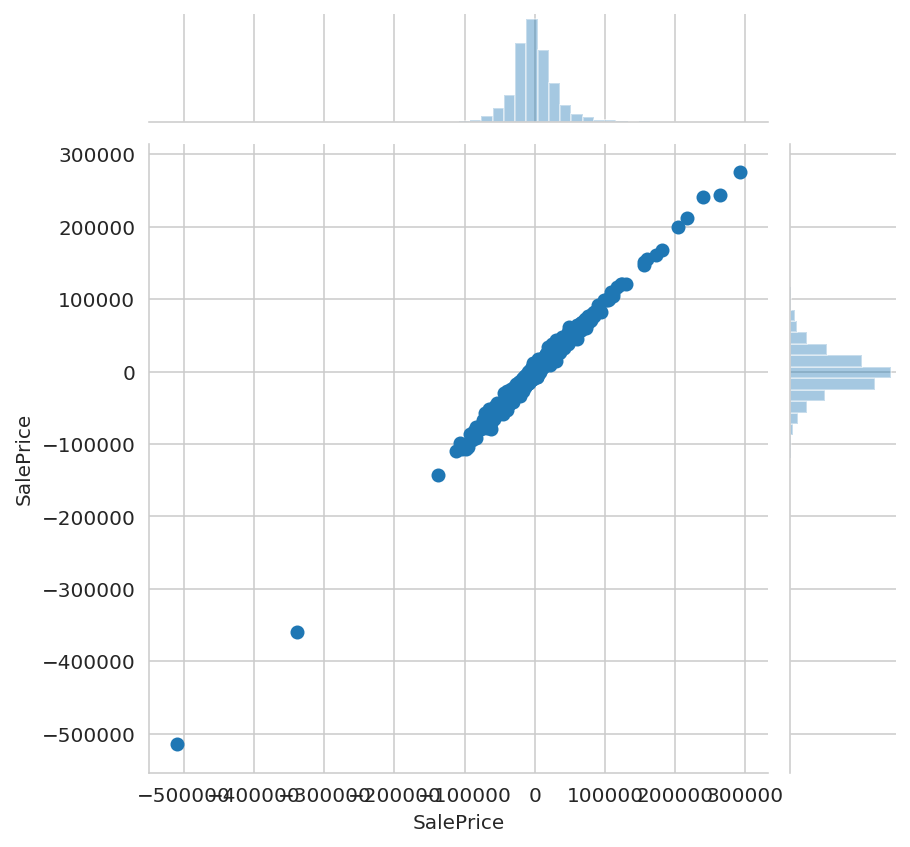

In [34]:
sns.jointplot(ridge_resid, lasso_resid)

In [35]:
residual_data = pd.DataFrame(list(zip(y, lasso_predict)), columns=['Actual SalePrice', 'Predicted SalePrice'])

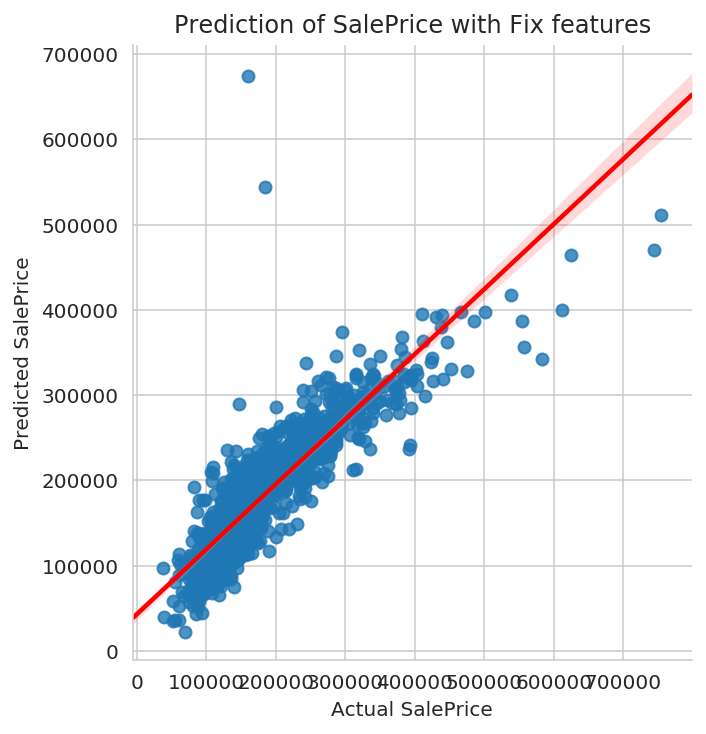

In [172]:
sns.lmplot(x='Actual SalePrice', y='Predicted SalePrice', data=residual_data, line_kws={'color': 'red'})
plt.title('Prediction of SalePrice with Fix features')
plt.show()

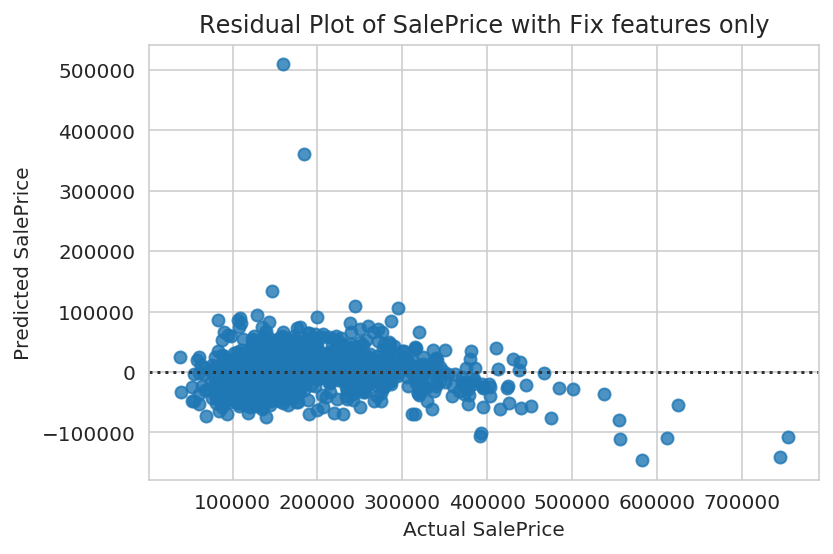

In [37]:
sns.residplot(x='Actual SalePrice', y='Predicted SalePrice', data=residual_data)
plt.title('Residual Plot of SalePrice with Fix features only')
plt.show()

In [38]:
# Q: Characterize your model. How well does it perform? What are the best estimates of price?
# A:

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [78]:
house_change = house[['RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 
                      'Heating', 'CentralAir', 'Electrical', 'Fireplaces', 'WoodDeckSF', 'PoolQC',
                      'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'Fence', 
                      'MiscFeature', 'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual',
                      'BsmtCond', 'BsmtExposure', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageFinish',
                      'GarageQual', 'GarageCond'
                    ]]

In [79]:
mms = MinMaxScaler()
Xn = mms.fit_transform(house_change)

In [80]:
xdf = pd.DataFrame(Xn)
xdf.columns = ['RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 
                      'Heating', 'CentralAir', 'Electrical', 'Fireplaces', 'WoodDeckSF', 'PoolQC',
                      'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'Fence', 
                      'MiscFeature', 'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual',
                      'BsmtCond', 'BsmtExposure', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageFinish',
                      'GarageQual', 'GarageCond']

In [101]:
Xn = xdf.values
y = house.SalePrice

In [102]:
Xn_train, Xn_test, yn_train, yn_test = train_test_split(Xn, y, test_size=0.8,random_state=5)

slr = LinearRegression()
slr.fit(Xn_train, yn_train)

cross_val_score(slr, Xn, y, cv=5)
slr.score(Xn_test,yn_test)

0.6877638016852365

In [103]:
slr_score = cross_val_score(slr, Xn, y, cv=5)
slr_score.max()

0.7430309937384019

In [113]:
las = Lasso()

Xn_train, Xn_test, yn_train, yn_test = train_test_split(Xn, y, test_size=0.8,random_state=5)
las.fit(Xn_train,yn_train)

las_score = cross_val_score(las, Xn, y, cv=10)
las.score(Xn_test,yn_test)

0.6881794477379972

In [114]:
las_score.max()

0.7888134964304687

In [115]:
ridge = Ridge()

Xn_train, Xn_test, yn_train, yn_test = train_test_split(Xn, y, test_size=0.8,random_state=5)
ridge.fit(Xn_train,yn_train)

ridge_score = cross_val_score(ridge, Xn, y, cv=10)
ridge.score(Xn_test,yn_test)

0.6889652466906512

In [116]:
ridge_score.max()

0.7913248318311802

In [117]:
knn = KNeighborsClassifier()

Xn_train, Xn_test, yn_train, yn_test = train_test_split(Xn, y, test_size=0.8,random_state=5)

knn.fit(Xn_train,yn_train)

knn_score = cross_val_score(las, Xn, y, cv=10)
knn.score(Xn_test,yn_test)

0.004336513443191674

In [89]:
knn_score.max()

0.7888134964304687

In [90]:
# prepare a range of alpha values to test
alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
# create and fit a ridge regression model, testing each alpha
model = Ridge()
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))
grid.fit(Xn_train,yn_train)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)

GridSearchCV(cv=None, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 0.e+00])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)
0.7471544941364899
0.1


/home/glitch/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.01386e-18): result may not be accurate.
  overwrite_a=True).T


In [91]:
# prepare a uniform distribution to sample for the alpha parameter
param_grid = {'alpha': sp_rand()}
# create and fit a ridge regression model, testing random alpha values
model = Ridge()
rsearch = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=100)
rsearch.fit(Xn_train,yn_train)
print(rsearch)
# summarize the results of the random parameter search
print(rsearch.best_score_)
print(rsearch.best_estimator_.alpha)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                                   max_iter=None, normalize=False,
                                   random_state=None, solver='auto',
                                   tol=0.001),
                   iid='deprecated', n_iter=100, n_jobs=None,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa88932cd10>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)
0.7485012237087428
0.35611957576008557


## Model

In [118]:
ridge = Ridge()

ridge.fit(Xn,y)
ridge.score(Xn,y)

0.742489905716113

In [119]:
lasso = Lasso()

lasso.fit(Xn,y)
lasso.score(Xn,y)

0.745828573980508

In [120]:
lasso_predict_CHG = lasso.predict(Xn)

In [121]:
Predicted_SalePrice_CHG = pd.DataFrame(lasso_predict_CHG, columns=['Predicted SalePrice_CHG'])

In [122]:
merge_table_chg_fix = pd.concat([house.SalePrice, Predicted_SalePrice_CHG, Predicted_SalePrice_Fix],axis=1)

In [123]:
merge_table_chg_fix.dropna(inplace=True)

In [124]:
merge_table_chg_fix

,SalePrice,Predicted SalePrice_CHG,Predicted SalePrice_Fix
0,"208,500.00","196,245.93","225,051.55"
1,"181,500.00","196,978.11","185,142.07"
2,"223,500.00","218,630.07","224,919.59"
3,"140,000.00","174,707.67","217,593.77"
4,"250,000.00","262,089.26","283,901.79"
...,...,...,...
1436,"120,500.00","164,303.30","196,576.90"
1437,"394,617.00","196,107.11","228,275.01"
1438,"149,700.00","250,140.87","198,514.41"
1439,"197,000.00","158,325.86","135,069.10"


In [125]:
cost_effect_comparison = merge_table_chg_fix[['SalePrice','Predicted SalePrice_CHG','Predicted SalePrice_Fix']].copy()

# add new column to calculate cost of renovation effect:
cost_effect_comparison['Cost of Renovation Effect'] = merge_table_chg_fix['Predicted SalePrice_CHG'] - merge_table_chg_fix['Predicted SalePrice_Fix']

# add new column to calculate the % increase in predicted SalePrice factoring renovate-able features:
cost_effect_comparison['% of Increase due to Renovation'] = cost_effect_comparison['Cost of Renovation Effect']/cost_effect_comparison['Predicted SalePrice_CHG']*100

cost_effect_comparison.sort_values('% of Increase due to Renovation', ascending=False).head(10)

# cost of Reno effect = Predicted SalePrice_CHG - Predicted SalePrice_Fix
# Impact of reno effect is presented through % of Increase in SalePrice

,SalePrice,Predicted SalePrice_CHG,Predicted SalePrice_Fix,Cost of Renovation Effect,% of Increase due to Renovation
29,"68,500.00","91,717.23","22,605.08","69,112.16",75.35
697,"123,500.00","138,537.84","36,677.91","101,859.94",73.52
122,"136,000.00","132,563.77","43,040.68","89,523.09",67.53
1164,"194,000.00","128,889.60","44,555.50","84,334.09",65.43
1430,"192,140.00","171,146.75","64,678.42","106,468.33",62.21
21,"139,400.00","182,821.63","75,046.62","107,775.01",58.95
987,"395,192.00","147,631.78","64,167.42","83,464.36",56.54
1305,"325,000.00","155,929.58","68,542.17","87,387.41",56.04
629,"168,500.00","82,055.27","36,305.27","45,749.99",55.76
575,"118,500.00","146,186.69","65,382.77","80,803.92",55.27


In [127]:
coefficient_CHG = pd.DataFrame({'variable':house_change.columns,
                                'coef':lasso.coef_,
                                'abs_coef':np.abs(lasso.coef_)})

coefficient_CHG.sort_values('abs_coef', inplace=True, ascending=False)

coefficient_CHG.head()

,variable,coef,abs_coef
11,PoolQC,"-302,474.97","302,474.97"
19,OverallQual,"204,761.78","204,761.78"
16,PoolArea,"-198,715.31","198,715.31"
1,RoofMatl,"59,992.58","59,992.58"
9,Fireplaces,"55,561.88","55,561.88"


In [137]:
coefficient_CHG_df = pd.DataFrame(list(zip(house_change.columns, lasso.coef_)),columns=['Features','Coefficient'])
coefficient_CHG_df.sort_values('Coefficient', ascending=False).head(10)

,Features,Coefficient
19,OverallQual,"204,761.78"
1,RoofMatl,"59,992.58"
9,Fireplaces,"55,561.88"
10,WoodDeckSF,"50,579.19"
12,OpenPorchSF,"41,091.10"
0,RoofStyle,"34,999.38"
14,3SsnPorch,"28,889.78"
15,ScreenPorch,"25,793.24"
20,OverallCond,"22,907.03"
3,Exterior2nd,"15,541.21"


In [60]:
# A:

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [61]:
# A:
house.groupby(by='SaleCondition').size()

SaleCondition
0      96
1       4
2      10
3      20
4    1189
5     122
dtype: int64

In [173]:
new_house = house.drop(columns='SaleCondition', axis=1)

In [63]:
new_house.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [174]:
mms = MinMaxScaler()
Xn = mms.fit_transform(new_house)

In [175]:
X = pd.DataFrame(Xn)

In [176]:
X.columns = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal',
       'MoSold', 'YrSold', 'SaleType', 'SalePrice']

In [177]:
X
y = house['SaleCondition']

In [178]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=5)

In [179]:
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=15)

In [183]:
yhats = []
yhat_pps = []
conmats = []
confusions = []
train_indexs=[]
test_indexs=[]

for train_index,test_index in kf.split(X,y):
    xgbc = XGBClassifier()
        
#     print(train_index,test_index)
    X_train,X_test,y_train,y_test = X.iloc[train_index],X.iloc[test_index],y.iloc[train_index],y.iloc[test_index]

#     X_train, X_test, y_train, y_test = train_test_split(Xn, y, test_size=0.2, random_state=1,stratify=y)
    xgbc.fit(X_train, y_train)

# predictions and pred prob.
    train_indexs.append(train_index)
    test_indexs.append(test_index)
    yhat = xgbc.predict(X_test)
    yhat_pp = xgbc.predict_proba(X_test)
    conmat = np.array(confusion_matrix(y_test, yhat, labels=[0,1,2,3,4,5]))

    confusion = pd.DataFrame(conmat, index=['is_Abnormal','is_AdjLand','is_Alloca','is_Family','is_Normal','is_Partial'],
                             columns=['Abnorml', 'AdjLand', 'Alloca', 'Family', 'Normal', 'Partial'])
    
    yhats.append(yhat)
    yhat_pps.append(yhat_pp)
    conmats.append(conmat)
    confusions.append(confusion)
    
       
confusions


/home/glitch/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


[             Abnorml  AdjLand  Alloca  Family  Normal  Partial
 is_Abnormal        3        0       0       0      16        0
 is_AdjLand         0        0       0       0       1        0
 is_Alloca          0        0       1       0       1        0
 is_Family          0        0       0       0       4        0
 is_Normal          3        0       0       0     235        0
 is_Partial         0        0       0       0       0       25,
              Abnorml  AdjLand  Alloca  Family  Normal  Partial
 is_Abnormal        3        0       1       0      15        0
 is_AdjLand         0        0       0       0       0        0
 is_Alloca          0        0       1       0       1        0
 is_Family          0        0       0       0       4        0
 is_Normal          1        0       0       0     237        0
 is_Partial         0        0       0       0       0       25,
              Abnorml  AdjLand  Alloca  Family  Normal  Partial
 is_Abnormal        2        0       0

In [71]:
def get_classif(i,cl_1,cl_2):
    return new_house.iloc[test_indexs[i]][(yhats[i]==cl_1)&(y.iloc[test_indexs[i]]==cl_2)]

In [72]:
get_classif(4,0,0)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SalePrice
456,70,3,34.00,4571,1,0,3,3,0,4,0,17,2,2,0,5,5,5,1916,1950,1,1,0,0,2,0.00,3,4,0,4,4,4,6,0,6,0,624,624,1,1,0,4,624,720,0,1344,0,0,1,0,4,1,3,7,6,0,3,5,"1,916.00",3,3,513,1,1,2,0,0,96,0,0,0,3,4,1,0,5,2008,0,98000
1017,120,2,61.50,5814,1,1,0,3,0,1,0,22,2,2,4,2,8,5,1984,1984,1,1,6,6,2,0.00,2,4,1,2,4,0,2,1036,6,0,184,1220,1,2,1,4,1360,0,0,1360,1,0,1,0,1,1,2,4,6,1,0,1,"1,984.00",2,2,565,5,5,2,63,0,0,0,0,0,3,4,1,0,8,2009,0,187500
1131,20,2,63.00,10712,1,1,3,3,0,4,0,11,2,2,0,2,5,5,1991,1992,1,1,6,6,2,0.00,3,4,2,2,4,2,1,212,6,0,762,974,1,4,1,4,974,0,0,974,0,0,1,0,3,1,3,5,6,0,3,6,"1,978.47",1,0,0,3,3,2,0,28,0,0,0,0,3,2,1,0,9,2007,7,93500


In [182]:
xgbc = XGBClassifier()
xgbc.fit(X, y)
yhat_xgbc = xgbc.predict(X)
yhat_xgbc_pp = xgbc.predict_proba(X)

conmat = np.array(confusion_matrix(y, yhat_xgbc, labels=[0,1,2,3,4,5]))

confusion = pd.DataFrame(conmat, index=['is_Abnormal','is_AdjLand','is_Alloca','is_Family','is_Normal','is_Partial'],
                               columns=['Abnorml', 'AdjLand', 'Alloca', 'Family', 'Normal', 'Partial'])
    
confusion

,Abnorml,AdjLand,Alloca,Family,Normal,Partial
is_Abnormal,50,0,0,0,46,0
is_AdjLand,0,4,0,0,0,0
is_Alloca,0,0,10,0,0,0
is_Family,0,0,0,8,12,0
is_Normal,0,0,0,0,1189,0
is_Partial,0,0,0,0,1,121


In [184]:
house.SaleCondition.value_counts()

4    1189
5     122
0      96
3      20
2      10
1       4
Name: SaleCondition, dtype: int64

In [ ]:
coefs_vars = pd.DataFrame({
        'coef':xgbc.coef_[0],
        'variable':X.columns,
        'abscoef':np.abs(xgbc.coef_[0])
    })
coefs_vars.sort_values('abscoef', ascending=False, inplace=True)
coefs_vars

In [ ]:
aa.columns

In [ ]:
aa = get_classif(4,0,0)
mmsa = MinMaxScaler()
Xa = mms.fit_transform(aa)

In [ ]:
coef_t = pd.DataFrame(Xa)

In [ ]:
coef_t.columns = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal',
       'MoSold', 'YrSold', 'SaleType', 'SalePrice']

In [ ]:
coef_t.dropna(inplace=True)

In [ ]:
corr = coef_t.corr() 
plt.figure(figsize=(20, 15))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);